In [5]:
import pandas as pd
import numpy as np

import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima_model import ARIMA

from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [6]:
# Load AIR PASSENGERS data

air_passengers_data = pd.read_csv(r"D:\time_series_session\AirPassengers.csv")

In [7]:
# Reindexing for the timestamp Column

air_passengers_data['Passengers'] = air_passengers_data['#Passengers']
air_passengers_data.drop(columns=['#Passengers'], inplace=True)

air_passengers_data['Month'] = pd.to_datetime(air_passengers_data['Month'])
air_passengers_data.set_index('Month', inplace=True)

In [8]:
# Check for the Missing Values
temp_idx = pd.date_range( min(air_passengers_data.index), max(air_passengers_data.index), freq='MS' )
missing_values_length = len(temp_idx) - len(air_passengers_data)

missing_values_length

0

In [9]:
### -- Method to Perform Augmented Dickey Fuller Test

def adf_test(df):

    dftest = adfuller(df, autolag='AIC')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [10]:
### FIRST ORDER DIFFERENCING

air_passengers_data['FIRST_ORDER_DIFF'] = air_passengers_data.Passengers - air_passengers_data.Passengers.shift(1)
#air_passengers_data_first_diff.dropna(inplace=True)

In [11]:
### CHECK THE ADF - STATIONARITY FOR THE DIFFERENCED DATA
adf_test( air_passengers_data.FIRST_ORDER_DIFF.dropna(inplace=False) )

Test Statistic                  -2.829267
p-value                          0.054213
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [12]:
### REMOVE THE SEASONALITY by DIFFERENCING WITH 'PERIOD INTERVAL = 12'

air_passengers_data['SEASONAL_DIFF'] = air_passengers_data.Passengers - air_passengers_data.Passengers.shift(12)

In [13]:
### CHECK THE ADF - STATIONARITY FOR THE SEASONAL DIFFERENCED DATA
adf_test( air_passengers_data.SEASONAL_DIFF.dropna(inplace=False) )

Test Statistic                  -3.383021
p-value                          0.011551
#Lags Used                       1.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [14]:
### FIT THE DATA TO THE SARIMA
mod = SARIMAX(air_passengers_data.Passengers, order=(0,1,0), seasonal_order=(1,1,1,12))
sarimax_results = mod.fit()
print (sarimax_results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         Passengers   No. Observations:                  144
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -513.064
Date:                            Thu, 07 Feb 2019   AIC                           1032.128
Time:                                    10:50:53   BIC                           1040.753
Sample:                                01-01-1949   HQIC                          1035.633
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.4435      0.527     -0.841      0.400      -1.477       0.590
ma.S.L12       0.2736      0.572   

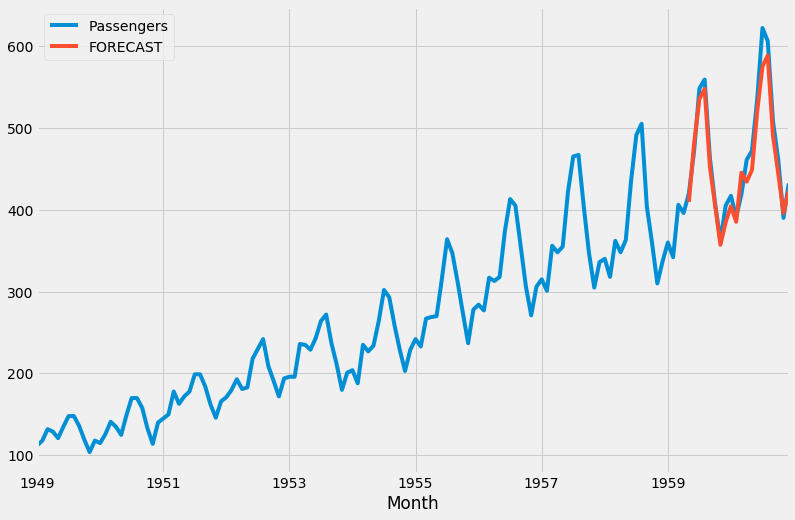

In [58]:
### COMPARE THE ACTUAL & FORECAST
air_passengers_data['FORECAST'] = sarimax_results.predict(start= (len(air_passengers_data) - 20), end=(len(air_passengers_data)-1), dynamic=True )

air_passengers_data[['Passengers', 'FORECAST']].plot(figsize=(12, 8))

In [15]:
### Split Train-Test:

Train = air_passengers_data[:125]
Test = air_passengers_data[125:]

In [17]:
### Implement Holts-Winter Method:

fit1 = ExponentialSmoothing(Train['Passengers'], seasonal='add', seasonal_periods=12).fit()

y_hat_avg = Test.copy()
y_hat_avg['Holt_Winter'] = fit1.predict(start=Test.index[0], end=Test.index[-1])

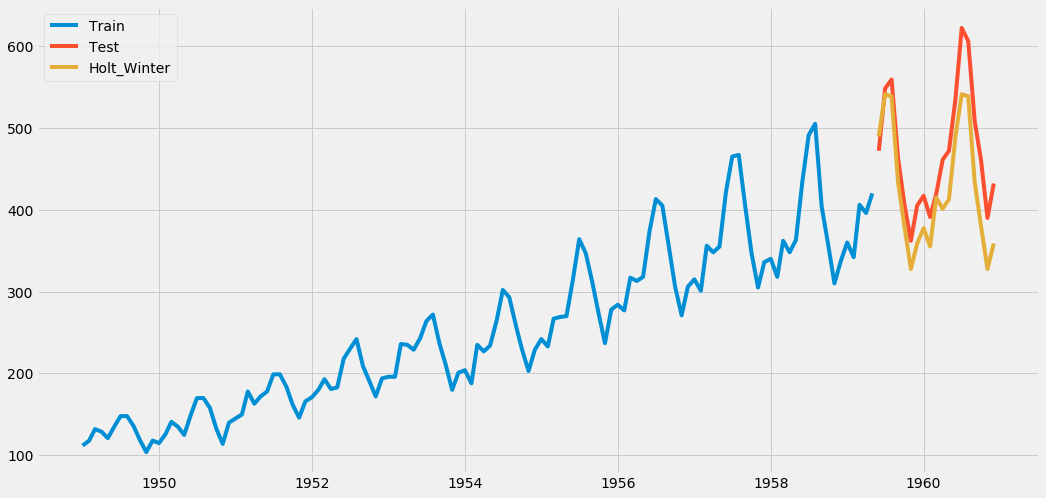

In [18]:
### Plotting the Data & Validation

plt.figure(figsize=(16,8))
plt.plot(Train.index, Train['Passengers'], label='Train')
plt.plot(Test.index,Test['Passengers'], label='Test')
plt.plot(y_hat_avg.index, y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')